# Bachelor's thesis

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import parquet
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

## Loading the data 

In [2]:
accepts = pd.DataFrame()
accepts = df = pd.read_parquet("../data/accepts_original.parquet", engine="fastparquet")

In [3]:
accepts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## Correlation Analysis

### First I drop the variables who are mostly missing and drop all missing observations in the variable loan_status. Then I categorize loan_status accordingly and drop uncertain values, as well as current loans where we don't know if they will default or not.

In [4]:
accepts = accepts.dropna(thresh=accepts.shape[0]*0.9,axis=1)

In [5]:
accepts.dropna(subset=['loan_status'], inplace=True)

/var/folders/gq/_cdvcqp945l0bvvrdmswyvs80000gn/T/ipykernel_13249/1322065774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepts.dropna(subset=['loan_status'], inplace=True)


In [6]:
accepts = accepts[~accepts.loan_status.isin([
    "Does not meet the credit policy. Status:Fully Paid",
    "Does not meet the credit policy. Status:Charged Off",
    "Current"
])]

def categorize_loan(x):
    if(x=='Fully Paid' or x=='Late (31-120 days)' or x=='In Grace Period' or x=="Late (16-30 days)"):
        return 0
    return 1
accepts['loan_status'] = accepts['loan_status'].apply(categorize_loan)

In [7]:
y = accepts.pop("loan_status")

In [8]:
accepts = accepts.select_dtypes(exclude=['object'])

In [9]:
accepts = pd.concat([accepts,y],axis = 1)

In [10]:
accepts = accepts.drop("policy_code", axis = 1)

## Now I calculate the correlations between variables

In [11]:
correlation = accepts.corr(numeric_only=True)

In [12]:
correlation_loan_status = correlation["loan_status"]
correlation_loan_status = correlation_loan_status.sort_values(ascending=False)

## These are the variables who are correlate the most with loan_status

In [13]:
correlation_loan_status.head(10)

loan_status                1.000000
recoveries                 0.506531
collection_recovery_fee    0.481314
int_rate                   0.247396
total_rec_late_fee         0.099842
acc_open_past_24mths       0.096827
num_tl_op_past_12m         0.083203
dti                        0.079720
num_actv_rev_tl            0.068807
num_rev_tl_bal_gt_0        0.067594
Name: loan_status, dtype: float64

In [14]:
correlation_loan_status.tail(10)

avg_cur_bal            -0.077028
bc_open_to_buy         -0.080444
fico_range_high        -0.127334
fico_range_low         -0.127336
total_pymnt_inv        -0.304011
total_pymnt            -0.304403
last_pymnt_amnt        -0.335868
total_rec_prncp        -0.424318
last_fico_range_low    -0.562610
last_fico_range_high   -0.648539
Name: loan_status, dtype: float64

## I chose interest rate, bc_open_to_buy and acc_open_past_24mths to be my unobserved variables for my data generation process and displayed their correlation with a heatmap.

In [15]:
correlation_unobserved = accepts[['loan_status','int_rate',"bc_open_to_buy","acc_open_past_24mths"]]
correlation_unobserved.rename(columns={'loan_status': 'loan status', 'int_rate': 'interest rate',"bc_open_to_buy":'bankcard open to buy',"acc_open_past_24mths": "credit trades opened 24 months"}, inplace=True)


/var/folders/gq/_cdvcqp945l0bvvrdmswyvs80000gn/T/ipykernel_13249/3964591406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_unobserved.rename(columns={'loan_status': 'loan status', 'int_rate': 'interest rate',"bc_open_to_buy":'bankcard open to buy',"acc_open_past_24mths": "credit trades opened 24 months"}, inplace=True)


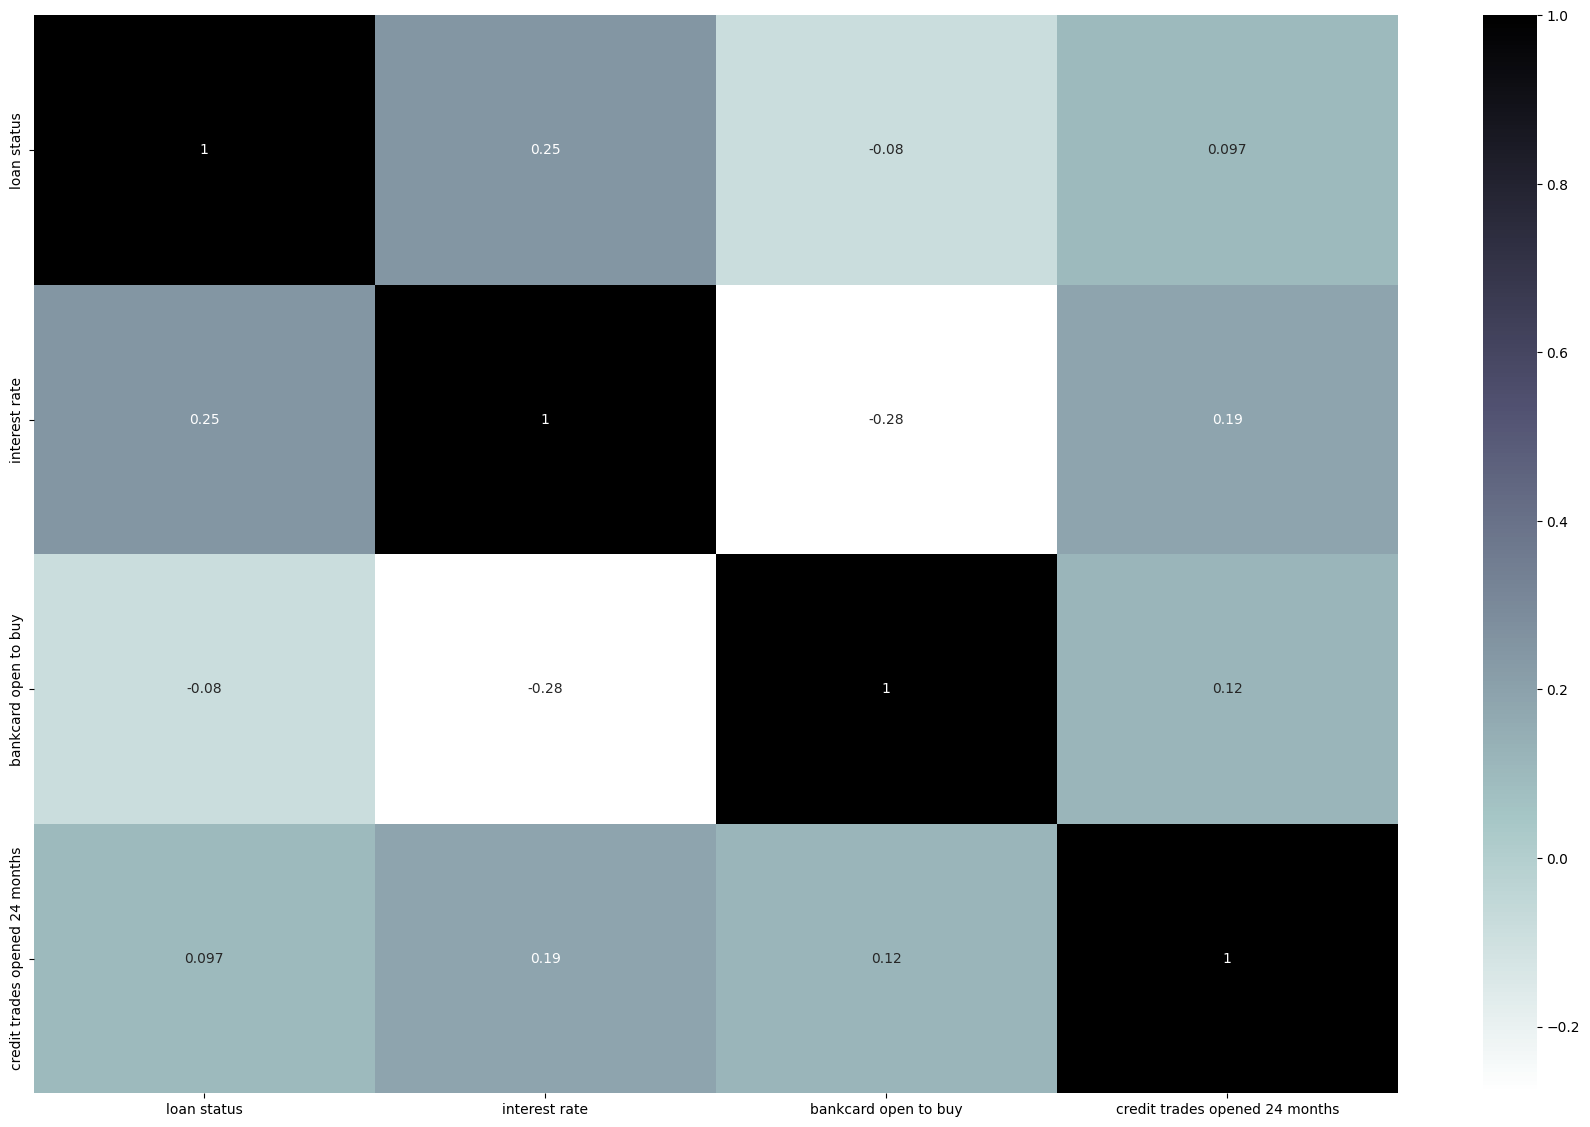

In [16]:
plt.figure(figsize=(22,14))
ax = sns.heatmap(correlation_unobserved.corr(numeric_only=True),annot=True, cmap='bone_r')
plt.show()